In [9]:
import tensorflow as tf

Importing relevant Python Libraries

In [10]:
# Basic Python

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from tqdm import tqdm

# Quant Libraries

import yfinance as yf # yahoo finance PyPi for getting stock data
import quandl # provides additional stock data
import nsepy # this gets derivatives data
#import pyfolio as pf # provides performance and risk analysis of financial portfolios
#import mplfinance as mpf # works in combination with matplotlib and pandas to plot finance data
import pandas_ta as ta # pandas but it also has TA indicators
#import nasdaqdatalink # this is the new version of quandl

# ML Models

import sklearn
import torch
import tensorflow as tf
#plt.style.use('seaborn-v0_8')

Calculating various market indicators for Apple Stock (AAPL)

Moving Average: Average close price of the stock over some time period up to now. In this example, we calculate the 50-day moving average.

RSI (Relative Strength Index): Measures the momentum of price movements - RSI = 100 - (100/(1+RS)), where RS is Relative Strength, the average gain for positive periods divided by the average loss for negative periods.

MACD (Moving Average Convergence Divergence) = 12-day EMA - 26-day EMA, where EMA (Exponential Moving Average) basically weights more recent prices more heavily.

Bollinger Bands: A measure of volatility which bounds the simple moving average by +- 2*(Standard Deviation over that time period).

Stochastic Oscillator: %K = (C - L_n)/(H_n - L_n), where C is the latest closing price, and H_n and L_n are the highest high and lowest low over the last n periods, respectively, and %D is the 3-day moving average of %K.

Average True Range: Average of max[(High - Low (for the day)), abs(High - Previous Close), abs(Low - Previous Close)] (where the last two capture movements that happen when trading isn't happening).

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-23  130.919998  132.419998  129.639999  131.860001  131.127045   
2022-12-27  131.380005  131.410004  128.720001  130.029999  129.307251   
2022-12-28  129.669998  131.029999  125.870003  126.040001  125.339417   
2022-12-29  127.989998  130.479996  127.730003  129.610001  128.889572   
2022-12-30  128.410004  129.949997  127.430000  129.929993  129.207794   

              Volume        MA50        RSI      MACD  Signal_Line  Middle_BB  \
Date                                                                            
2022-12-23  63814900  144.131800  26.261623 -3.670694    -2.570162   140.6610   
2022-12-27  69007800  143.964799  27.960271 -3.936230    -2.843375   139.9515   
2022-12-28  85438400  143.637399  26.152341 -4.417705    -3.158241   139.1950   
2022-12

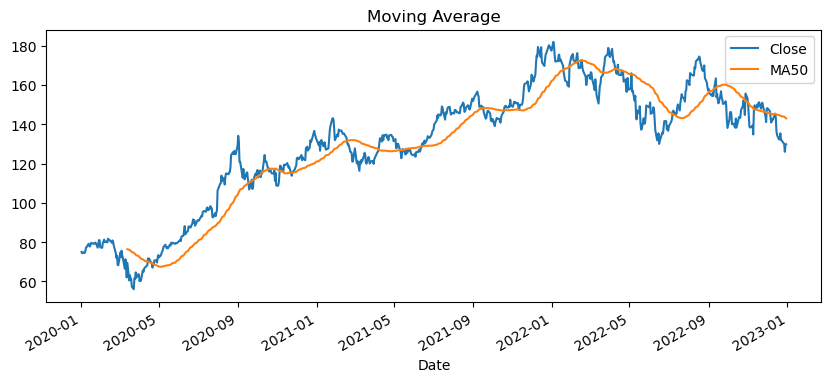

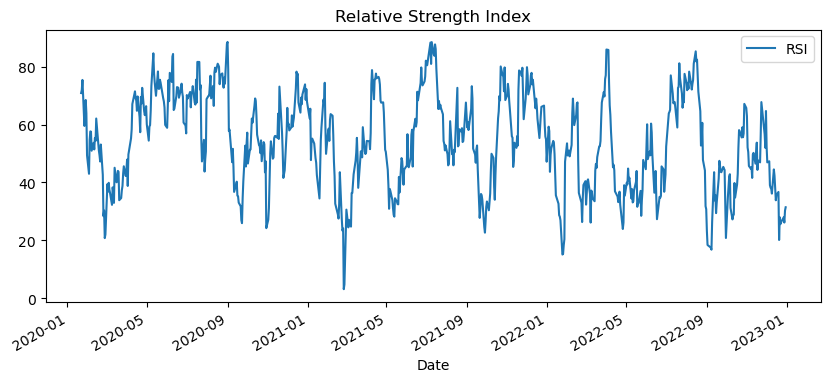

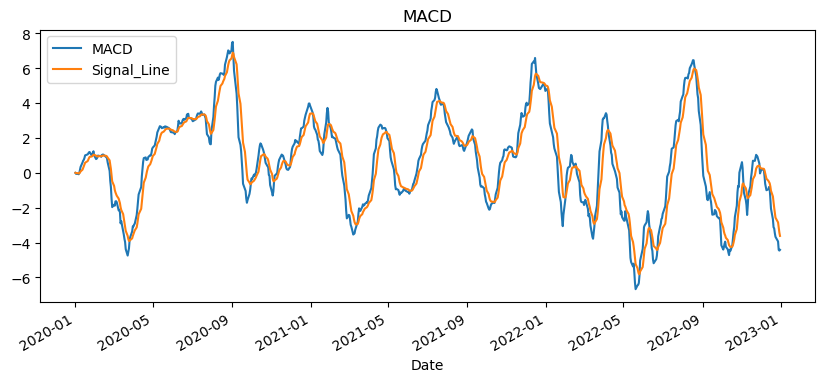

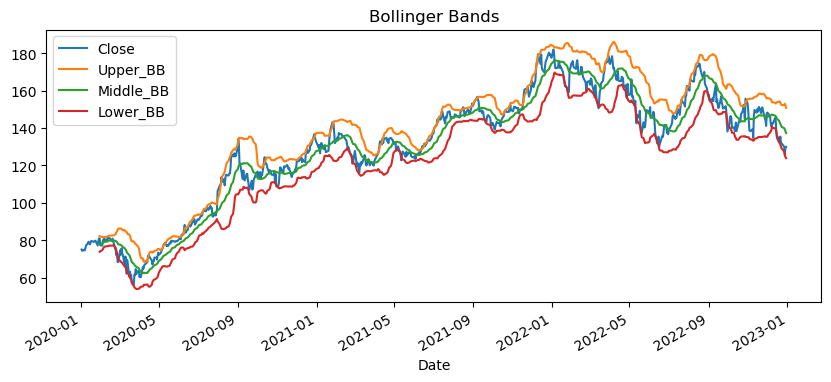

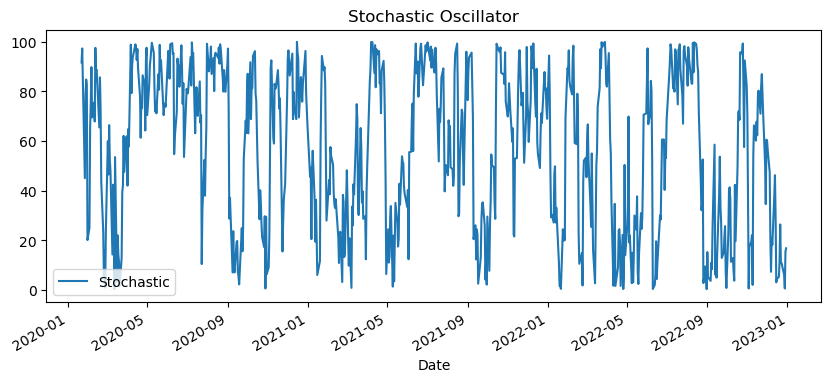

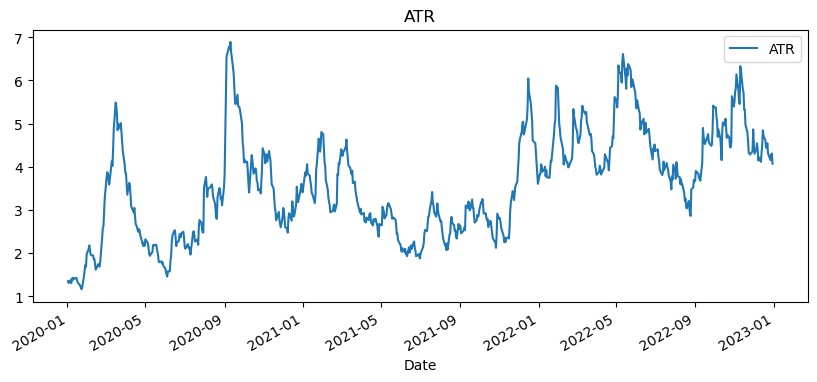

In [11]:
# Download stock data
df = yf.download("AAPL", start="2020-01-01", end="2023-01-01")

# Calculate Moving Average
df['MA50'] = df['Close'].rolling(window=50).mean()

# Calculate RSI
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Bands
df['Middle_BB'] = df['Close'].rolling(window=20).mean()
df['Upper_BB'] = df['Middle_BB'] + 2 * df['Close'].rolling(window=20).std()
df['Lower_BB'] = df['Middle_BB'] - 2 * df['Close'].rolling(window=20).std()

# Calculate Stochastic Oscillator
low_14 = df['Low'].rolling(window=14).min()
high_14 = df['High'].rolling(window=14).max()
df['Stochastic'] = 100 * (df['Close'] - low_14) / (high_14 - low_14)

# Calculate True Range
df['High-Low'] = df['High'] - df['Low']
df['High-Close'] = abs(df['High'] - df['Close'].shift())
df['Low-Close'] = abs(df['Low'] - df['Close'].shift())
df['True_Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

# Calculate ATR (14-day Exponential Moving Average of the True Range)
df['ATR'] = df['True_Range'].ewm(span=14, adjust=False).mean()
df.drop(['High-Low', 'High-Close', 'Low-Close', 'True_Range'], axis=1, inplace=True)

# Displaying the DataFrame
print(df.tail())

# Plotting the indicators
df[['Close', 'MA50']].plot(figsize=(10, 4), title='Moving Average')
plt.show()

df[['RSI']].plot(figsize=(10, 4), title='Relative Strength Index')
plt.show()

df[['MACD', 'Signal_Line']].plot(figsize=(10, 4), title='MACD')
plt.show()

df[['Close', 'Upper_BB', 'Middle_BB', 'Lower_BB']].plot(figsize=(10, 4), title='Bollinger Bands')
plt.show()

df[['Stochastic']].plot(figsize=(10, 4), title='Stochastic Oscillator')
plt.show()

df[['ATR']].plot(figsize=(10, 4), title='ATR')
plt.show()

Backtesting The Moving Average Crossover Strategy

Here, we backtest the following strategy on Apple Stock (AAPL) performance over the last three years:

Buy Signal --> 10-day moving average exceeds 50-day moving average

Sell Signal --> 10-day moving average dips back below 50-day moving average

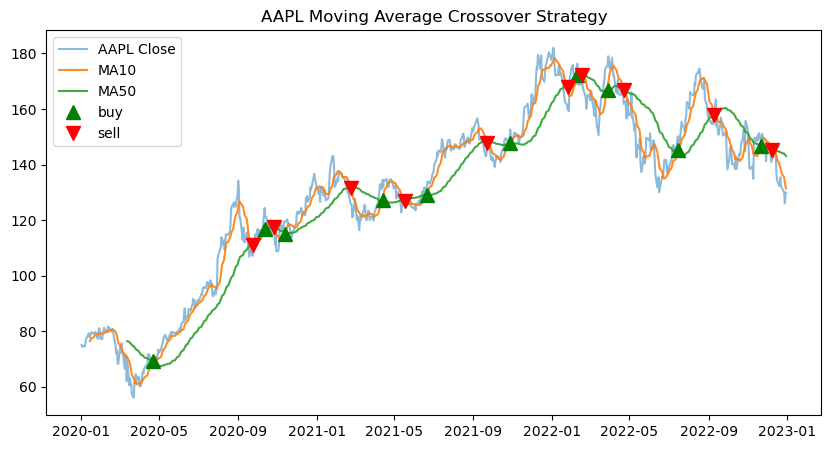

Initial Balance: $10000
Final Balance: $16136.64


In [12]:
# Calculate Moving Averages
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Generate signals
df['Signal'] = 0
df.iloc[10:, df.columns.get_loc('Signal')] = np.where(df['MA10'][10:] > df['MA50'][10:], 1, 0)
df['Position'] = df['Signal'].diff()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='AAPL Close', alpha=0.5)
plt.plot(df['MA10'], label='MA10', alpha=0.9)
plt.plot(df['MA50'], label='MA50', alpha=0.9)

# Buy signals
plt.plot(df[df['Position'] == 1].index, df['MA10'][df['Position'] == 1], '^', markersize=10, color='g', label='buy')

# Sell signals
plt.plot(df[df['Position'] == -1].index, df['MA10'][df['Position'] == -1], 'v', markersize=10, color='r', label='sell')

plt.title('AAPL Moving Average Crossover Strategy')
plt.legend()
plt.show()

# Backtest performance
initial_balance = 10000
balance = initial_balance
shares = 0

for index, row in df.iterrows():
    if row['Position'] == 1:  # Buy
        shares = balance / row['Close']
        balance = 0
    elif row['Position'] == -1 and shares > 0:  # Sell
        balance = shares * row['Close']
        shares = 0

final_balance = balance + shares * df.iloc[-1]['Close']
print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")